## AI Anomaly Detection in Cybersecurity Network Logs

### 1.Problem statement

- The goal of this project is to build an AI-driven anomaly detection system that identifies unusual or potentially malicious activity in network traffic using the UNSW-NB15 cybersecurity dataset. By applying unsupervised machine learning methods such as Isolation Forest and Autoencoders, the model learns normal network behavior and flags deviations that may indicate cyber threats or intrusions.
This project demonstrates how machine learning can enhance network security and threat detection by analyzing high-dimensional network log data.

### 2.Data Collection

- UNSW-NB15 Data : https://research.unsw.edu.au/projects/unsw-nb15-dataset

### 2.1 Import Data and Required Packages

Importing necessary libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Import the CSV Data as Pandas DataFrame

In [6]:
df = pd.read_csv("data/UNSW_NB15_training-set.csv")

Show Top 5 Records

In [7]:
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


### 2.2 Dataset information

Shape of the dataset

In [8]:
df.shape

(82332, 45)

Features - 45

In [9]:
df.columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

### 3. Data Checks and Data Cleaning

### 3.1 Check Missing values

In [10]:
df.isna().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

There is no null values in the dataset

### 3.2 Check Duplicates

In [11]:
df.duplicated().sum()

np.int64(0)

There are no duplicates values in the dataset

### 3.3 Check data types

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

### 3.4 Check unique values in categorical columns

In [16]:
df['proto'].value_counts()

proto
tcp         43095
udp         29418
unas         3515
arp           987
ospf          676
            ...  
sccopmce       32
sps            32
pipe           32
ib             31
igmp           30
Name: count, Length: 131, dtype: int64

In [17]:
df['service'].value_counts()

service
-           47153
dns         21367
http         8287
smtp         1851
ftp          1552
ftp-data     1396
pop3          423
ssh           204
ssl            30
snmp           29
dhcp           26
radius          9
irc             5
Name: count, dtype: int64

Replacing '-' with 'unknown' in 'service' column

In [19]:
df['service']=df["service"].replace('-','unknown', regex=True)

In [20]:
df['state'].value_counts()

state
FIN    39339
INT    34163
CON     6982
REQ     1842
ACC        4
RST        1
CLO        1
Name: count, dtype: int64

In [21]:
df['attack_cat'].value_counts()

attack_cat
Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: count, dtype: int64

In [22]:
df['label'].value_counts()

label
1    45332
0    37000
Name: count, dtype: int64

### 3.5 Basic Numeric Statistics

In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,82332.0,4.116650e+04,2.376735e+04,1.0,20583.750000,4.116650e+04,6.174925e+04,8.233200e+04
dur,82332.0,1.006756e+00,4.710444e+00,0.0,0.000008,1.413800e-02,7.193603e-01,5.999999e+01
spkts,82332.0,1.866647e+01,1.339164e+02,1.0,2.000000,6.000000e+00,1.200000e+01,1.064600e+04
dpkts,82332.0,1.754594e+01,1.155741e+02,0.0,0.000000,2.000000e+00,1.000000e+01,1.101800e+04
sbytes,82332.0,7.993908e+03,1.716423e+05,24.0,114.000000,5.340000e+02,1.280000e+03,1.435577e+07
dbytes,82332.0,1.323379e+04,1.514715e+05,0.0,0.000000,1.780000e+02,9.560000e+02,1.465753e+07
rate,82332.0,8.241089e+04,1.486204e+05,0.0,28.606114,2.650177e+03,1.111111e+05,1.000000e+06
sttl,82332.0,1.809677e+02,1.015134e+02,0.0,62.000000,2.540000e+02,2.540000e+02,2.550000e+02
dttl,82332.0,9.571300e+01,1.166677e+02,0.0,0.000000,2.900000e+01,2.520000e+02,2.530000e+02
sload,82332.0,6.454902e+07,1.798618e+08,0.0,11202.466797,5.770032e+05,6.514286e+07,5.268000e+09


### 3.6 Distribution of labels

In [28]:
df['label'].value_counts(normalize=True)

label
1    0.5506
0    0.4494
Name: proportion, dtype: float64

Dataset is balanced

### 3.7 Check for constant columns

In [29]:
df.nunique().sort_values().head(10)

is_sm_ips_ports      2
label                2
is_ftp_login         3
ct_ftp_cmd           3
state                7
ct_state_ttl         7
trans_depth          8
dttl                 8
ct_flw_http_mthd     8
attack_cat          10
dtype: int64

### 3.8 Look for suspicious or zero-heavy columns

In [30]:
(df == 0).sum().sort_values(ascending=False).head(10)

is_ftp_login         81654
ct_ftp_cmd           81652
is_sm_ips_ports      81416
response_body_len    76675
ct_flw_http_mthd     74752
trans_depth          74750
djit                 41552
dloss                41204
ackdat               41160
tcprtt               41127
dtype: int64

### 3.9 Dropping unnecessary columns

In [31]:
df.drop(columns='id', inplace=True)

#### Initial Data Exploration

- The dataset contains X rows and 45 columns.
- Numeric columns describe packet statistics, bytes, jitter, TTL values, load, flows, etc.
- Categorical columns include: proto, service, state, and attack_cat.
- service contains 13 unique values.
- No major missing values, but some categorical values need normalization (e.g., replacing '-' with 'unknown').
- The target label (label) is balance: approx 55% normal and 44% attack.
- Some columns are highly skewed (e.g., duration, bytes), which requires scaling before modeling.

### 4. Exploring Data ( Visualization )

#### 4.1 Label Distribution (Normal vs Attack)

In [34]:
sns.set(style="whitegrid", palette="deep")
plt.rcParams['figure.figsize'] = (8,5)

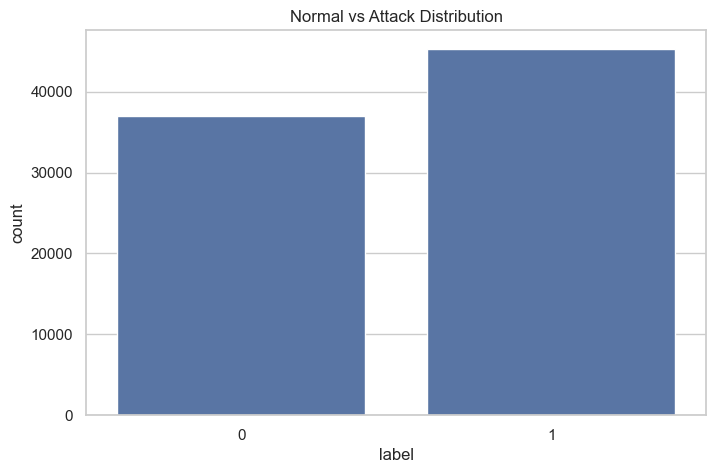

In [35]:
sns.countplot(x='label', data=df)
plt.title('Normal vs Attack Distribution')
plt.show()

Dataset is balanced

#### 4.2 Attack Category Distribution

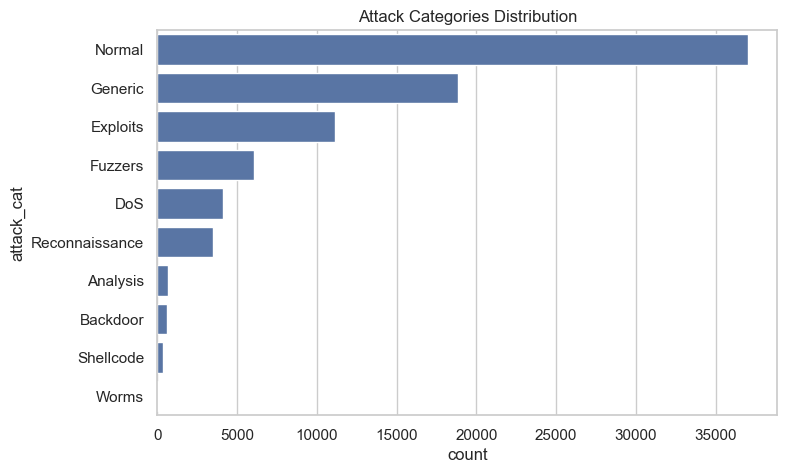

In [37]:
sns.countplot(y='attack_cat', data=df, order=df['attack_cat'].value_counts().index)
plt.title('Attack Categories Distribution')
plt.show()

- Generic, Exploits, Fuzzers - these attack types are dominant
- Severe imbalance across attack types.

#### 4.3 Protocol Distribution (proto)

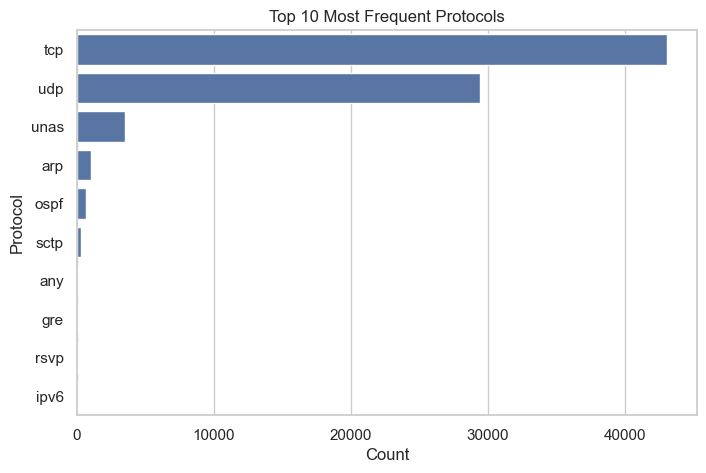

In [40]:
top_protos = df['proto'].value_counts().head(10)

sns.barplot(x=top_protos.values, y=top_protos.index)
plt.title("Top 10 Most Frequent Protocols")
plt.xlabel("Count")
plt.ylabel("Protocol")
plt.show()

- TCP and UDP dominates

#### 4.4 Service Distribution

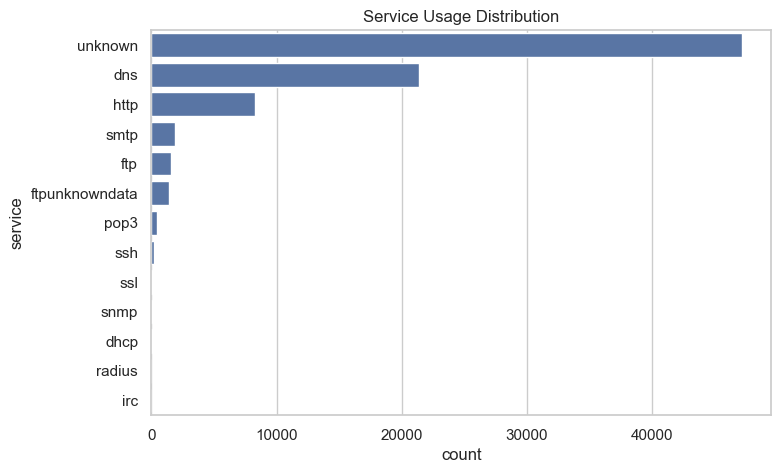

In [41]:
sns.countplot(y='service', data=df, order=df['service'].value_counts().index)
plt.title('Service Usage Distribution')
plt.show()

#### 4.5. Correlation Heatmap (Top 15 Features)

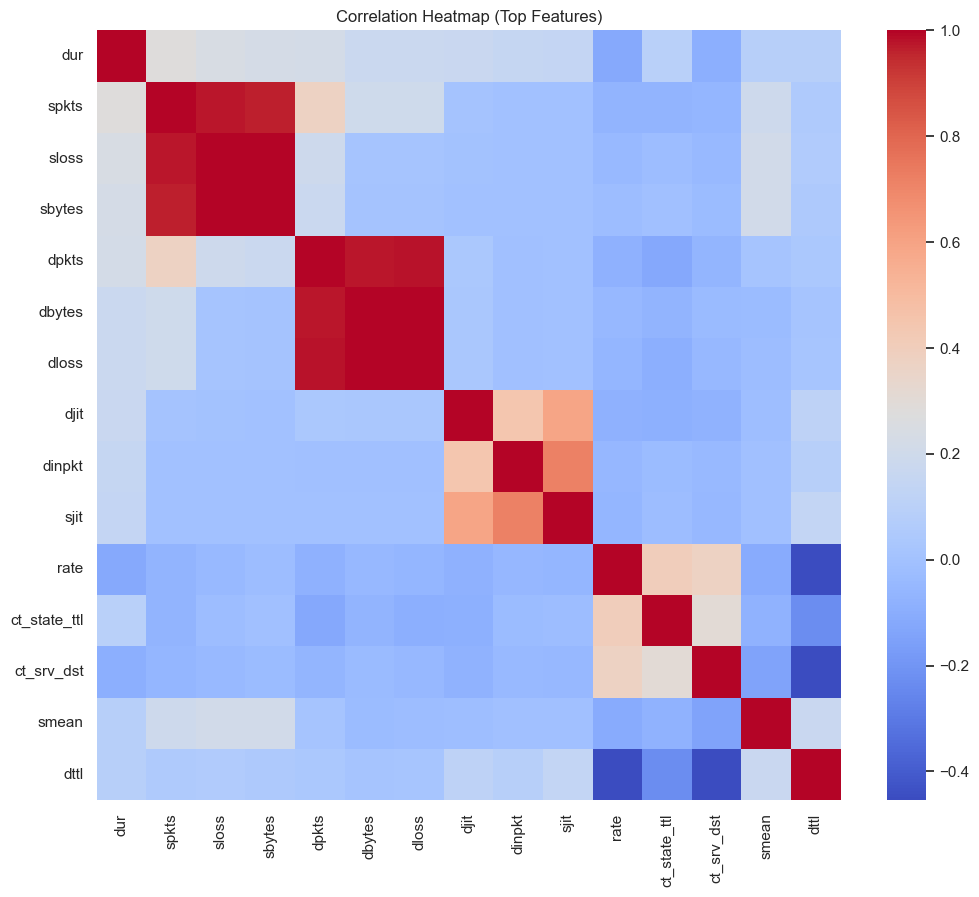

In [ ]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
top_corr = numeric_df.corr().abs().nlargest(15, 'dur').index  # picking top correlated with 'dur' or any reference
corr = numeric_df[top_corr].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap (Top Features)')
plt.show()

#### 4.6 Distribution of Key Numeric Features

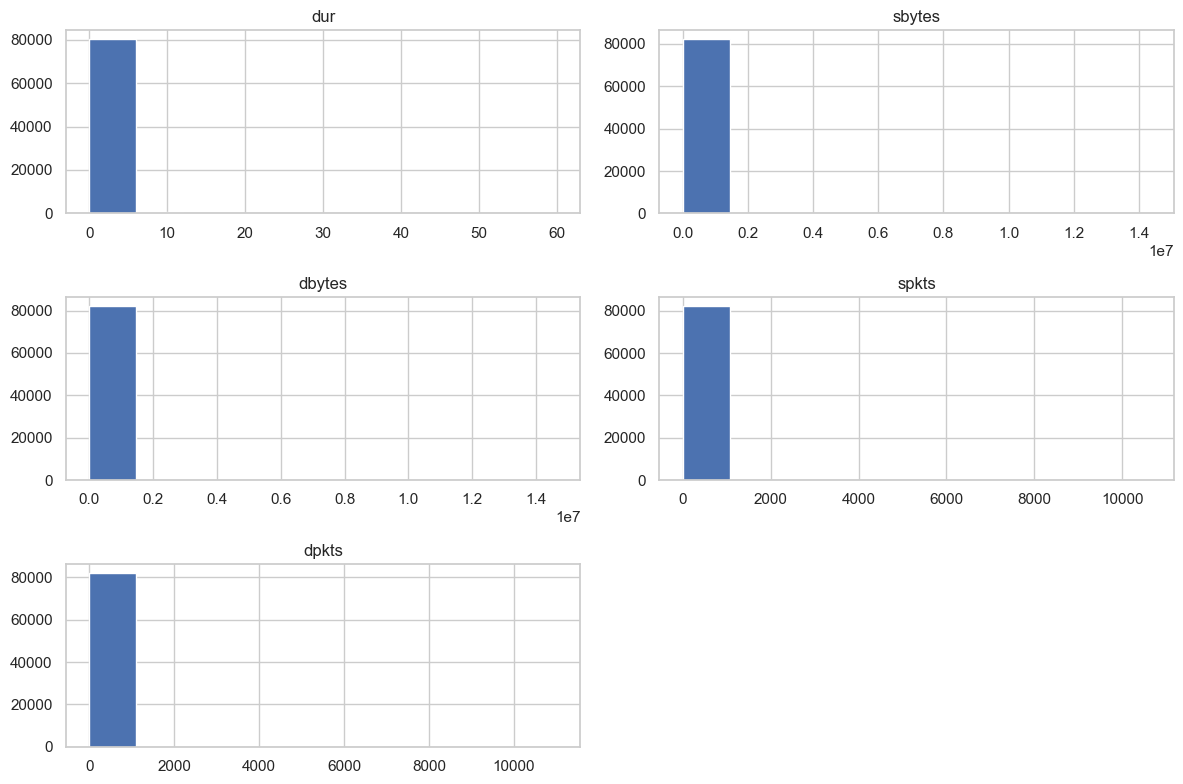

In [44]:
cols_to_plot = ['dur', 'sbytes', 'dbytes', 'spkts', 'dpkts']
df[cols_to_plot].hist(figsize=(12,8))
plt.tight_layout()
plt.show()

These features ['dur', 'sbytes', 'dbytes', 'spkts', 'dpkts'] have long-tail distributions:

- 98–99% of values are VERY small
- a few values are EXTREMELY large (outliers)

#### 4.7 Boxplots to Detect Outliers

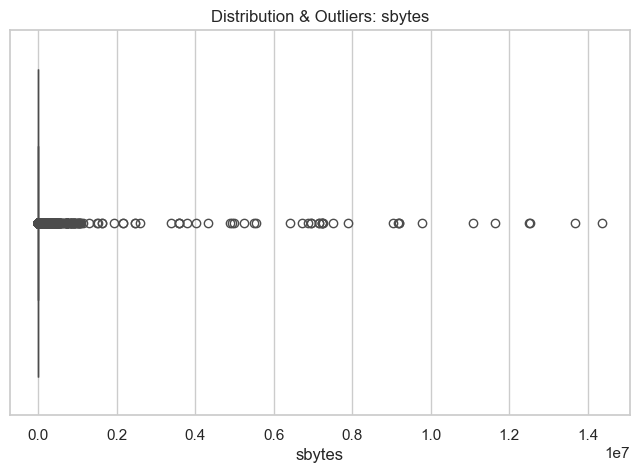

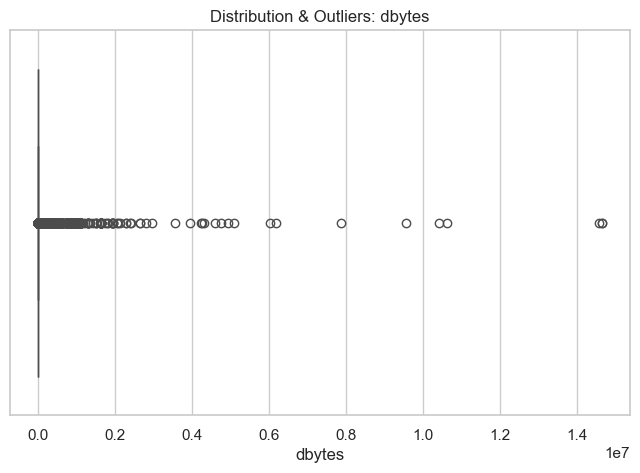

In [45]:
sns.boxplot(x=df['sbytes'])
plt.title('Distribution & Outliers: sbytes')
plt.show()

sns.boxplot(x=df['dbytes'])
plt.title('Distribution & Outliers: dbytes')
plt.show()

- Lots of extreme outliers (Isolation Forest will detect these!)

#### 4.8 Pairplot for Attack vs Normal

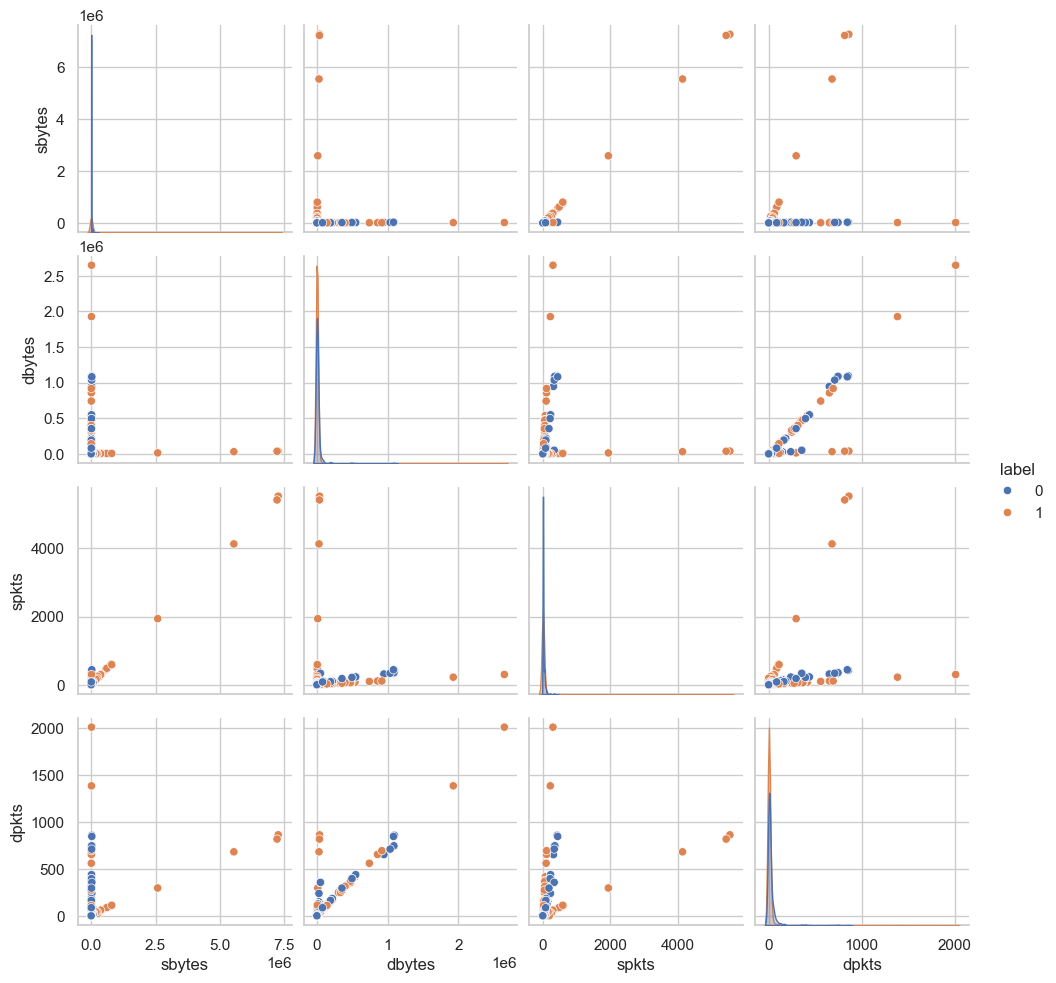

In [46]:
sample = df.sample(5000, random_state=42)

sns.pairplot(sample, vars=['sbytes','dbytes','spkts','dpkts'], hue='label')
plt.show()

#### EDA Summary

- The dataset is balance, with slightly more traffic being normal (label 0).
- Certain attack types dominate (Generic, Exploits), leading to skewed class distribution.
- Key network features such as sbytes, dbytes, spkts, and dpkts show heavy skewness and many outliers — suitable for anomaly detection.
- Protocol and service distributions show realistic network patterns.
- Correlation analysis reveals strong relationships between packet- and byte-related features.
- Overall, the dataset contains rich network metadata appropriate for building anomaly detection models.